# Similarity search ECML tutorial Notebook

The goal of Time Series Similarity search is to asses the similarities between a time series, denoted as a query `q` of length `l`, and a collection of time series, denoted as `X`, which lengths are superior or equal to `l`. In this context, the notion of similiarity between `q` and the other series in `X` is quantified by similarity functions. Those functions are most of the time defined as distance function, such as the Euclidean distance. Knowing the similarity between `q` and other admissible candidates, we can then perform many other tasks, such as anomaly or motif detection.

More [code examples](https://github.com/aeon-toolkit/aeon/blob/main/examples/similarity_search/similarity_search.ipynb), [theoritical lessons](https://github.com/aeon-toolkit/aeon/blob/main/examples/similarity_search/distance_profiles.ipynb) and [benchmarks](https://github.com/aeon-toolkit/aeon/blob/main/examples/similarity_search/code_speed.ipynb) can be found on the aeon documentation examples notebooks for the similarity search module

In [1]:
!pip install aeon==0.11.1
!pip install seaborn
!mkdir -p data
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/ECMLKDD-2024/main/Notebooks/data/Coffee.ts -P data/

In [1]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore")

We'll start by importing the `Coffee` dataset, and defining some functions we'll use for plotting !

In [2]:
from matplotlib import pyplot as plt
from aeon.datasets import load_from_tsfile

# Comment those lines if you didn't install seaborn !
import seaborn as sns 
sns.set()
sns.set_context('talk')

# Load the univariate TSC dataset as a 3D numpy array
X, y = load_from_tsfile("./data/Coffee.ts", return_type="numpy3D")

# If you have trouble loading the dataset from the data folder, use this instead :
# from aeon.datasets import load_classification
# X, y = load_classification('Coffee')

print("X shape:", X.shape)

X_cls_0 = X[y=='0']
X_cls_1 = X[y=='1']

def plot_best_matches(top_k_search, best_matches, q, max_display_size=None):
    fig, ax = plt.subplots(figsize=(20, 5), ncols=len(best_matches))
    for i_k, (id_sample, id_timestamp) in enumerate(best_matches):
        if len(best_matches) == 1:
            _ax = ax
        else:
            _ax = ax[i_k]
        # plot the sample of the best match
        _ax.plot(top_k_search.X_[id_sample, 0], linewidth=2)
        # plot the location of the best match on it
        match = top_k_search.X_[id_sample, 0, id_timestamp : id_timestamp + q.shape[1]]
        _ax.plot(
            range(id_timestamp, id_timestamp + q.shape[1]),
            match,
            linewidth=7,
            alpha=0.5,
            color="green",
            label="best match location",
        )
        # plot the query on the location of the best match
        _ax.plot(
            range(id_timestamp, id_timestamp + q.shape[1]),
            q[0],
            linewidth=5,
            alpha=0.5,
            color="red",
            label="query",
        )
        _ax.set_title(f"best match {i_k} from $X {id_sample}$")
        _ax.legend()
        if max_display_size is not None:
            _ax.set_xlim(id_timestamp - q.shape[1] * max_display_size, id_timestamp + q.shape[1] * (1+max_display_size))
    plt.show()


def plot_matrix_profile(X1, X2, mp, i_k):
    fig, ax = plt.subplots(figsize=(20, 10), nrows=2)
    ax[0].set_title("series X used to build the matrix profile")
    if X1.ndim > 2:
        for i in range(len(X1)):
            ax[0].plot(X1[i,0], alpha=0.1)  # plot first channel only
    else:
        ax[0].plot(X1[0], label='X_fit')  # plot first channel only
    ax[0].plot(X2[0], label='X_predict')  # plot first channel only
    ax[0].legend()
    # This is necessary as mp is a list of arrays due to unequal length support
    # as it can have different number of matches for each step when
    # using threshold-based search.
    ax[1].plot([mp[i][i_k] for i in range(len(mp))])
    ax[1].set_title(f"Top {i_k+1} matrix profile of X")
    ax[1].set_ylabel(f"Dist to top {i_k+1} match")
    ax[1].set_xlabel("Starting index of the query in X")
    plt.show()

X shape: (56, 1, 286)


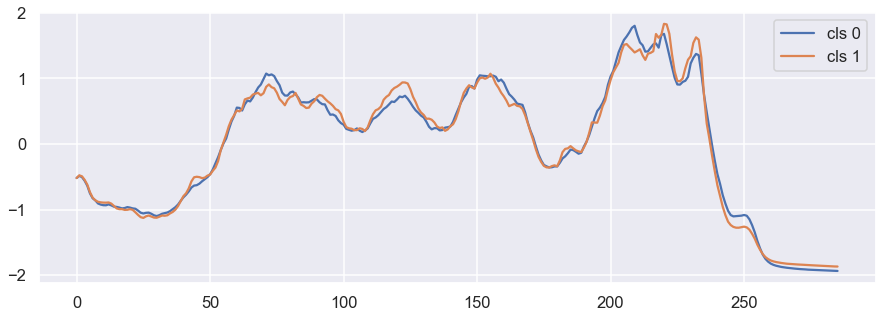

In [3]:
plt.figure(figsize=(15,5))
plt.plot(X_cls_0[0,0], label='cls 0')
plt.plot(X_cls_1[0,0], label='cls 1')
plt.legend()
plt.show()

## Expected inputs and format
For both `QuerySearch` and `SeriesSearch`, the fit method expects a time series dataset of shape `(n_cases, n_channels, n_timepoints)`. This can be 3D numpy array or a list of 2D numpy arrays if n_timepoints varies between cases (i.e. unequal length dataset). The predict methods expects a 2D array of shape :
- `(n_channels, query_length)` for query search
- `(n_channels, n_timepoints)` along with a length parameter `query_length` for series search. `n_timepoints` doesn't have to match with data in fit.

## Available estimators
Both `QuerySearch` and `SeriesSearch` inherit from the `BaseSimilaritySearch` class, which requires the following arguments:

- `distance` : a string indicating which distance function to use as similarity function. By default this is `euclidean`, which means that the Euclidean distance is used. The `distance_args` argument can be use for parameterized distances like `dtw`.
- `normalize` : a boolean indicating whether this similarity function should be z-normalized. This means that the scale of the two series being compared will be ignored, and that, loosely speaking, we will only focus on their shape during the comparison. By default, this parameter is set False.
- `inverse_distance` : If True, the matching will be made on the inverse of the distance, and thus, the  worst matches to the query will be returned instead of the best ones.
- `speed_up` : a string indicating which computational optimisation to use. By default, it will use the fastest. For both estimators, the class method `get_speedup_function_names` will return the accepted names for this parameter.
    

Another parameter, which has no effect on the output of the estimators, is a boolean named `store_distance_profile`, set to False by default and is only available for `QuerySearch`. If set to True, the estimators will expose an attribute named `_distance_profile` after the predict function is called. This attribute will contain the computed distance profile for query given as input to the predict function.

To illustrate how to work with similarity search estimators in aeon, we will now present some example use cases.

# Query Search 

## Case 1 : What is the best match of this query ?

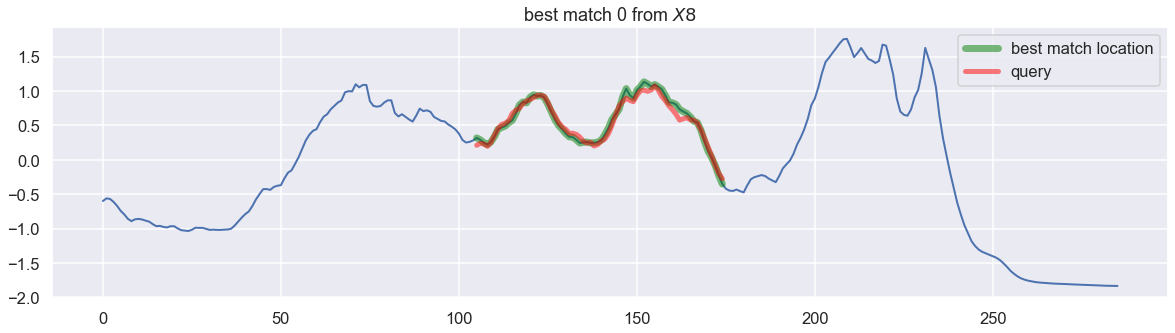

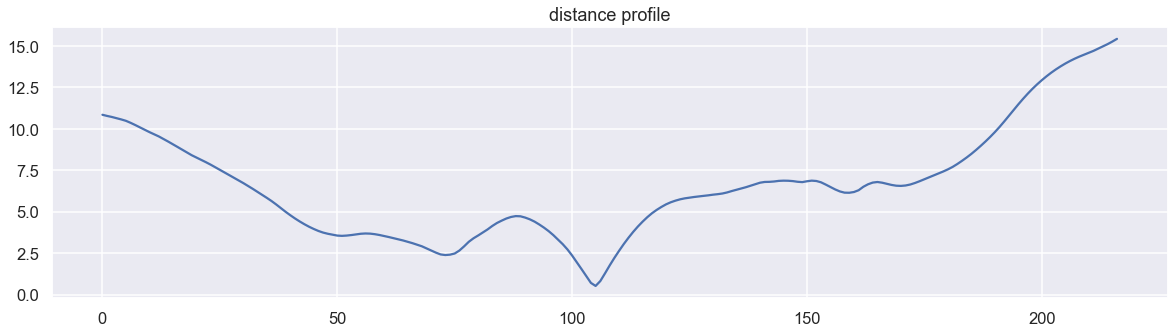

match 0 : [  8 105] with distance 0.5255619819570403 to q


In [21]:
from aeon.similarity_search import QuerySearch

search = QuerySearch(store_distance_profiles=True).fit(X_cls_0) # a 3D arrat of shape (n_cases, n_channels, n_timepoints)
query = X_cls_1[0, :, 105:175] # a 2D array of shape (n_channels, query_length)
dists, match_indexes = search.predict(query)
plot_best_matches(search, match_indexes, query)

plt.figure(figsize=(20,5))
plt.title('distance profile')
plt.plot(search.distance_profiles_[match_indexes[0][0]]) #dist profile of the best matching sample in X_cls_0
plt.show()

for i in range(len(match_indexes)):
    print(f"match {i} : {match_indexes[i]} with distance {dists[i]} to q")

## Case 1.5 : What are the k-best match of this query ?

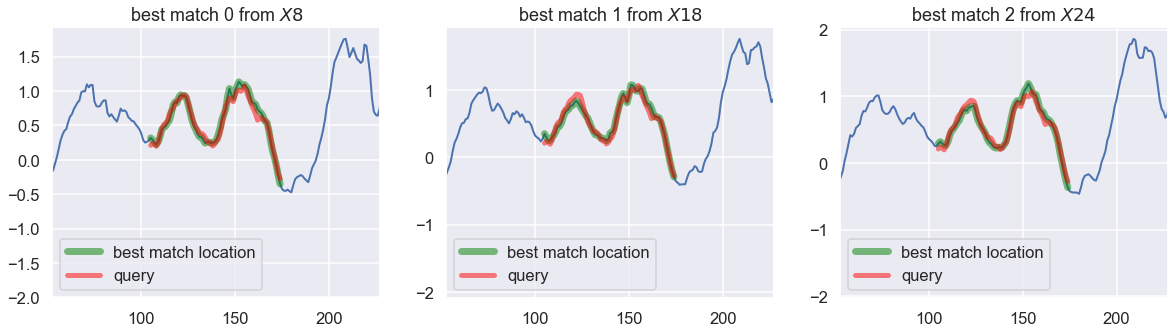

match 0 : [  8 105] with distance 0.5255619819570403 to q
match 1 : [ 18 105] with distance 0.5439180964000454 to q
match 2 : [ 24 105] with distance 0.5615301634218822 to q


In [5]:
search = QuerySearch(k=3).fit(X_cls_0) # a 3D arrat of shape (n_cases, n_channels, n_timepoints)
query = X_cls_1[0, :, 105:175] # a 2D array of shape (n_channels, query_length)
dists, match_indexes = search.predict(query)
plot_best_matches(search, match_indexes, query, max_display_size=0.75)
for i in range(len(match_indexes)):
    print(f"match {i} : {match_indexes[i]} with distance {dists[i]} to q")

## Case 2 : What is the worst match of this query using a normalized distance?

Note that the match and query displayed bellow are not z-normalized, but the computation is made on z-normalized subsequences

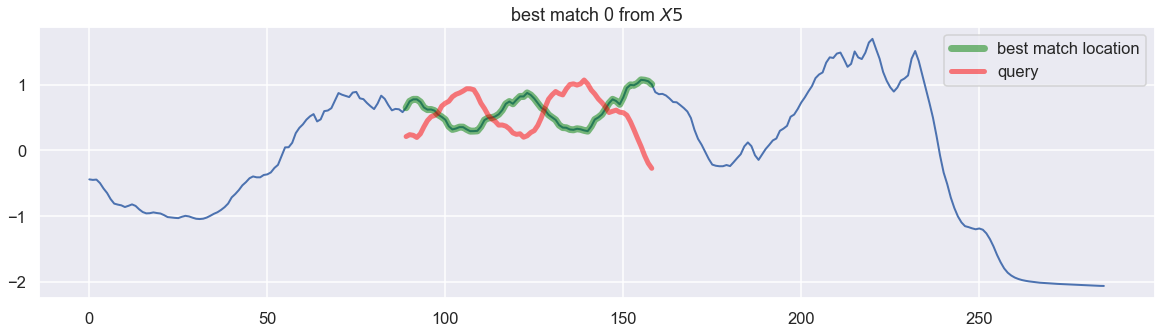

match 0 : [ 5 89] with distance 0.06160380628296105 to q


In [6]:
search = QuerySearch(normalize=True, inverse_distance=True).fit(X_cls_0) # a 3D arrat of shape (n_cases, n_channels, n_timepoints)
query = X_cls_1[0, :, 105:175] # a 2D array of shape (n_channels, query_length)
dists, match_indexes = search.predict(query)
plot_best_matches(search, match_indexes, query)
for i in range(len(match_indexes)):
    print(f"match {i} : {match_indexes[i]} with distance {dists[i]} to q")

# Series Search 

For series search, we are not interest in exploring the relationship of the input dataset `X` (given in `fit`) and a single query, but to all queries of size `query_length` that exists in another time series `X`.

## Case 1 : motifs and discords between two time series

Here, `mp` containts is a list of array containing the best matches distances to each query of size `query_length` in `X_cls_1[1]`, and `ip` a list of array containing the indexes of these best matches in the data given in fit.

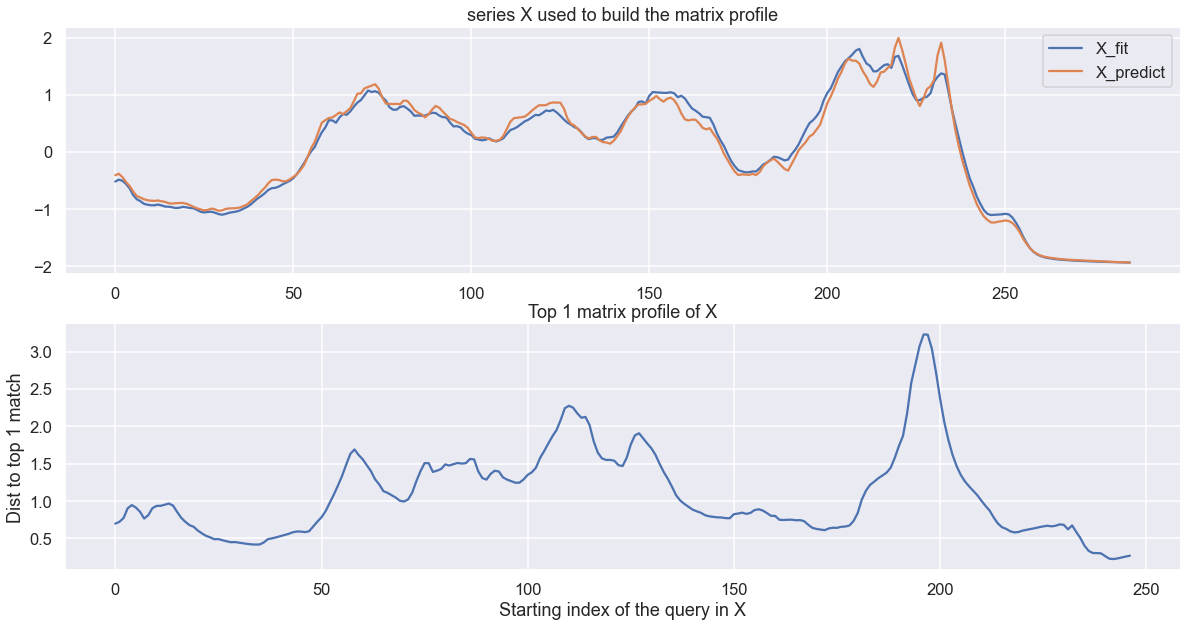

In [7]:
from aeon.similarity_search import SeriesSearch
query_length= 40
# We'll only use one sample for class 0 for now 
search = SeriesSearch(normalize=True).fit(X_cls_0[0:1])  # a 3D arrat of shape (n_cases, n_channels, n_timepoints)
mp, ip = search.predict(X_cls_1[1], query_length)
plot_matrix_profile(X_cls_0[0], X_cls_1[1], mp, 0)

### Inspecting the discord :

Again, subsequences displayed here are not z-normalized, while the computation is !

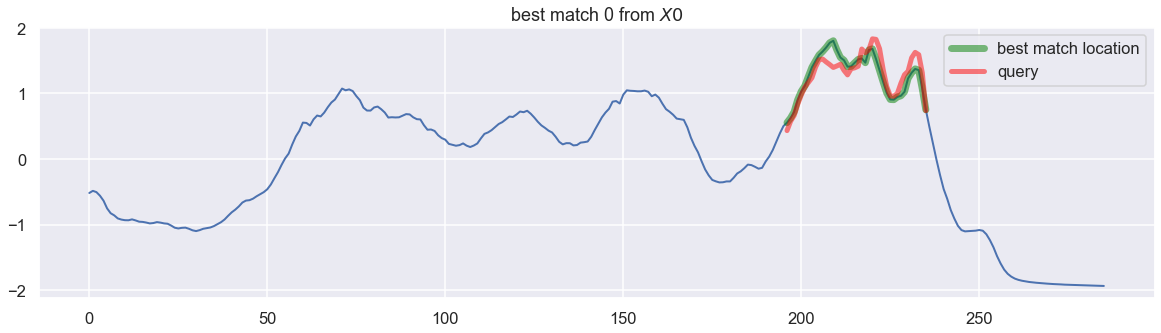

In [8]:
search = QuerySearch(normalize=True).fit(X_cls_0[0:1])
_index = ip[mp.argmax()] # array([[  0, 196]])
query = X_cls_1[_index[0,0], :, _index[0,1]:_index[0,1]+query_length] # a 2D array of shape (n_channels, query_length)
dists, match_indexes = search.predict(query)
plot_best_matches(search, match_indexes, query)

### Inspecting the motif :

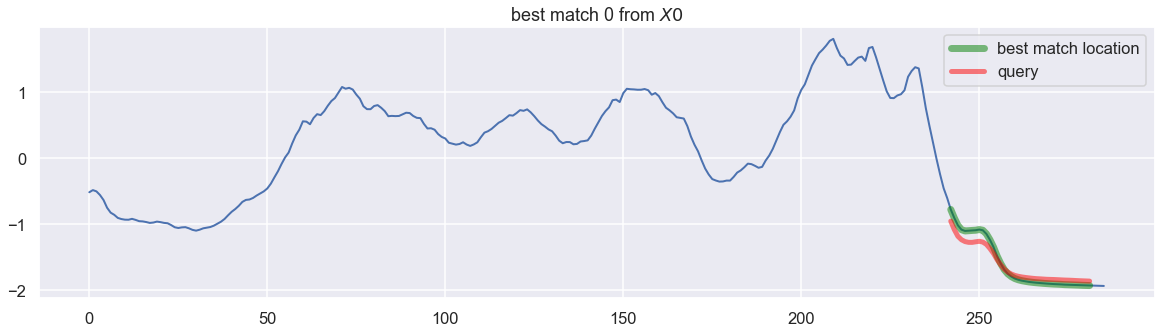

In [9]:
_index = ip[mp.argmin()] # array([[  0, 242]])
query = X_cls_1[_index[0,0], :, _index[0,1]:_index[0,1]+query_length] # a 2D array of shape (n_channels, query_length)
dists, match_indexes = search.predict(query)
plot_best_matches(search, match_indexes, query)

## Case 2 : motifs and discords in the same time series

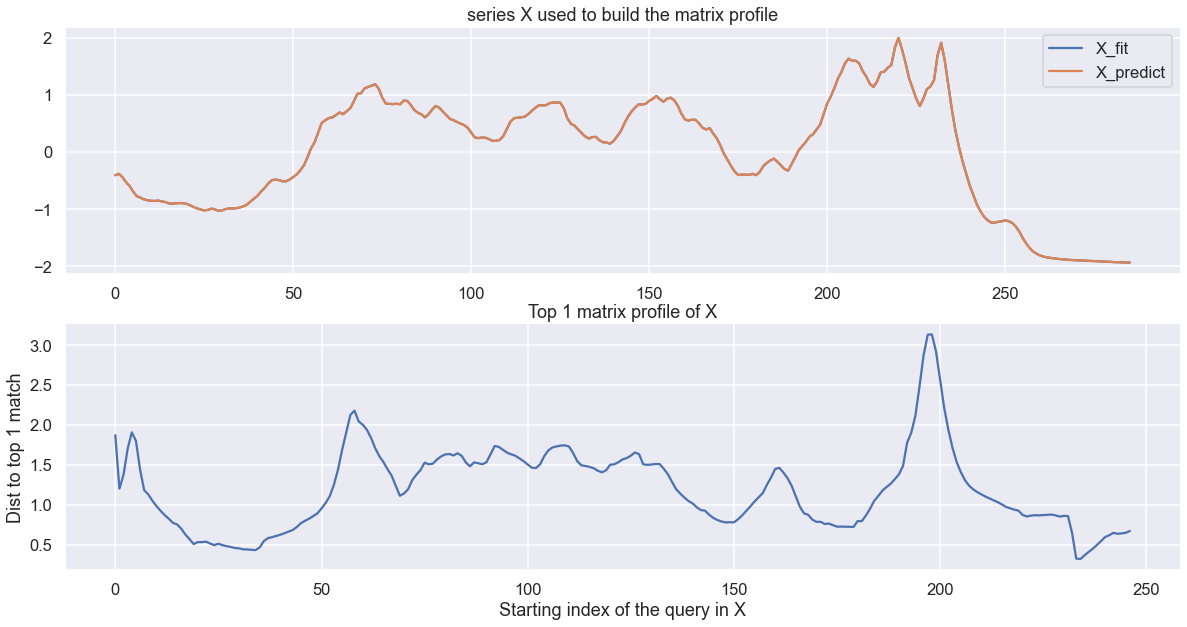

In [10]:
query_length= 40
# We'll only use one sample for class 0 for now 
search = SeriesSearch(normalize=True).fit(X_cls_1[1:2])  # a 3D arrat of shape (n_cases, n_channels, n_timepoints)
mp, ip = search.predict(X_cls_1[1], query_length, X_index=0)
plot_matrix_profile(X_cls_1[1], X_cls_1[1], mp, 0)

## Case 3 : motifs and discords to the other class

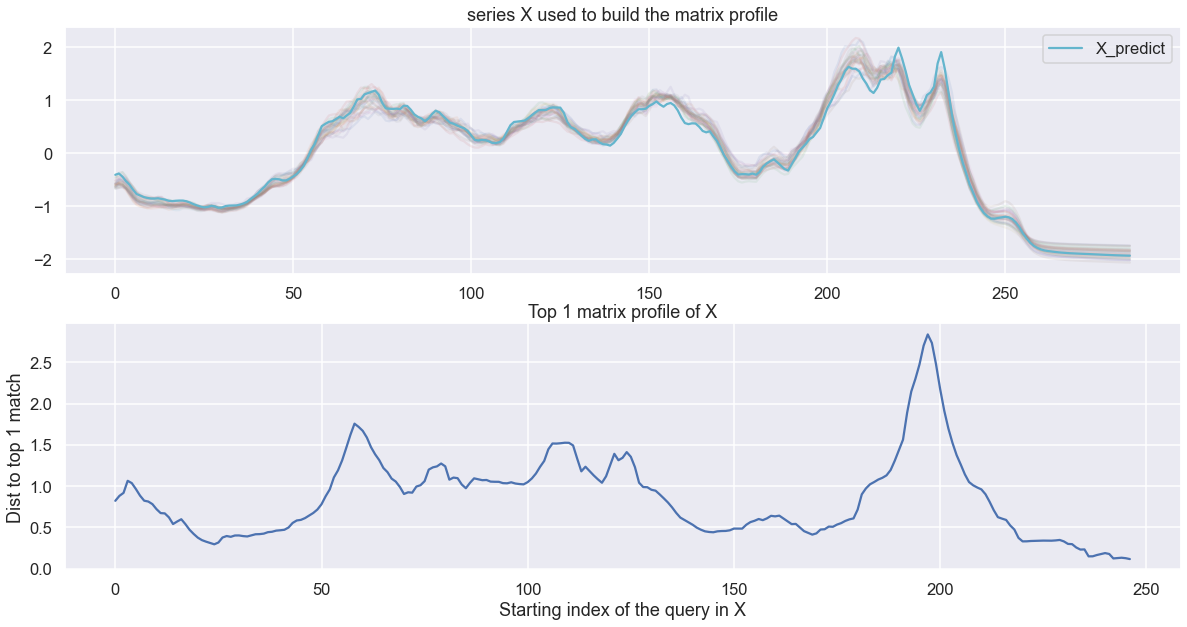

In [11]:
query_length= 40
# Now we use the full class samples
search = SeriesSearch(normalize=True).fit(X_cls_0)  # a 3D arrat of shape (n_cases, n_channels, n_timepoints)
mp, ip = search.predict(X_cls_1[1], query_length, X_index=0)
plot_matrix_profile(X_cls_0, X_cls_1[1], mp, 0)

## Visualize the discord on different samples from class 0

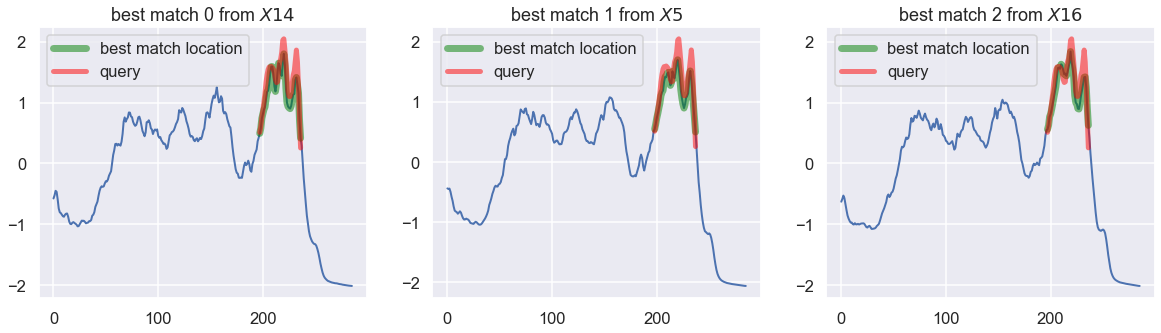

In [12]:
search = QuerySearch(normalize=True, k=3).fit(X_cls_0)
_index = ip[mp.argmax()] # array([[  0, 196]])
query = X_cls_1[_index[0,0], :, _index[0,1]:_index[0,1]+query_length] # a 2D array of shape (n_channels, query_length)
dists, match_indexes = search.predict(query, apply_exclusion_to_result=True) # avoid neighboring matches 
plot_best_matches(search, match_indexes, query)